Лабораторная работа 2.

«Наивный байесовский» классификатор. Target encoding. Логистическая регрессия.

Задание.

1. Загрузить таблицу Mushroom из репозитория UCI (любого источника) в объект DataFrame.
Вычислить распределение значений категориальных признаков по классам (использовать pd.groupby).
Визуализировать распределения.


2. Построить решающую функцию по каждой переменной на основе частот. Вычислить точность каждого решения (на той же обучающей выборке). Найти наиболее информативную переменную (с минимальным числом ошибок).

3. Построить «наивный» байесовский классификатор из sklearn (выбрать правильный вариант метода). Оценить точность.

4. Самостоятельно реализовать метод, не используя готовый. Сравнить полученное решение с библиотечным. Добавить регуляризатор в оценки частот.

5. Применить метод логистической регрессии, использовав в качестве переменных оценки вероятностей, подвергнутые обратному логистическому преобразованию.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
from sklearn.metrics import accuracy_score

In [ ]:
mushroom_cols = [
    "class", "cap_shape", "cap_surface", "cap_color", "bruises", "odor",
    "gill_attachment", "gill_spacing", "gill_size", "gill_color",
    "stalk_shape", "stalk_root", "stalk_surf_above_ring", "stalk_surf_below_ring",
    "stalk_color_above_ring", "stalk_color_below_ring", "veil_type", "veil_color",
    "ring_number", "ring_type", "spore_print_color", "population", "habitat"
]

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data'
mushrooms = pd.read_csv(data_url, header=None, names=mushroom_cols)

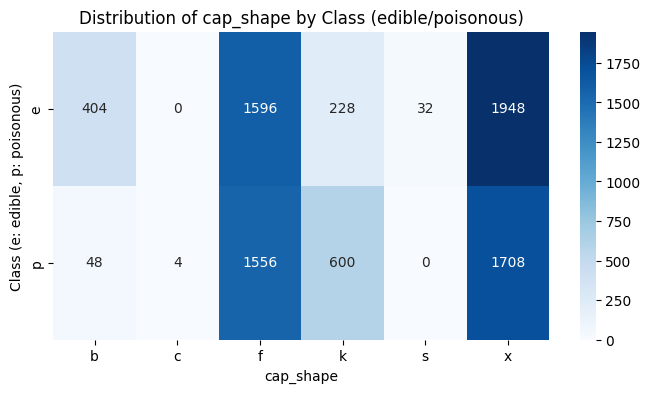

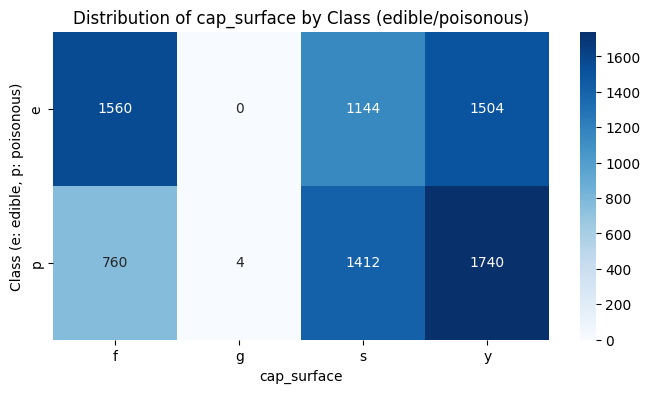

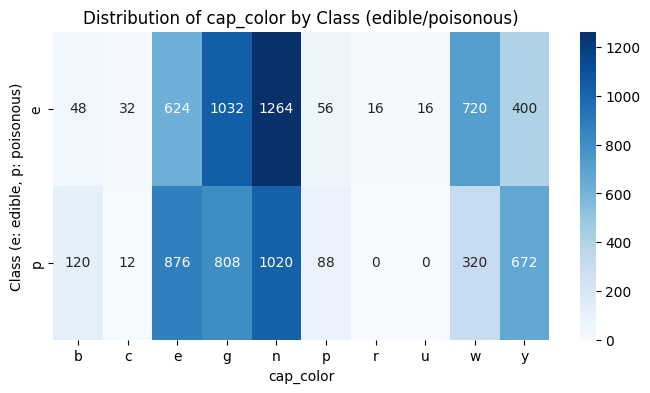

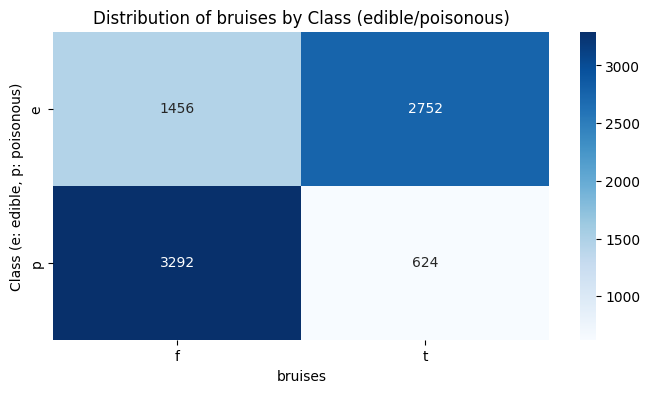

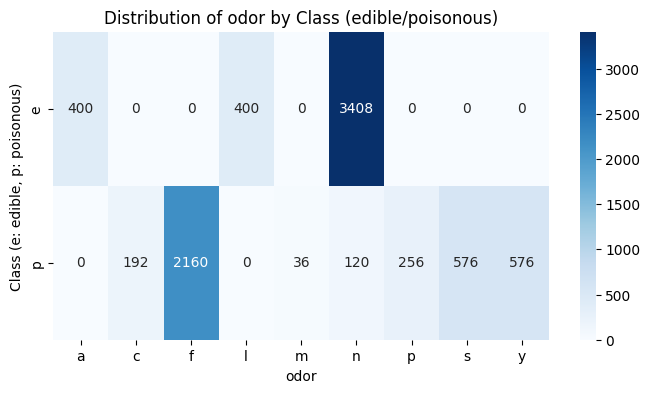

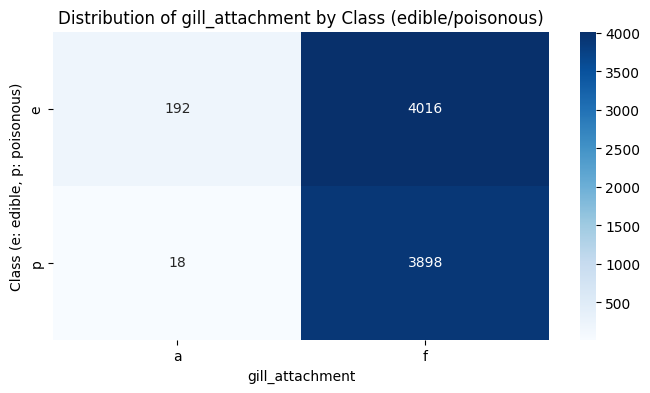

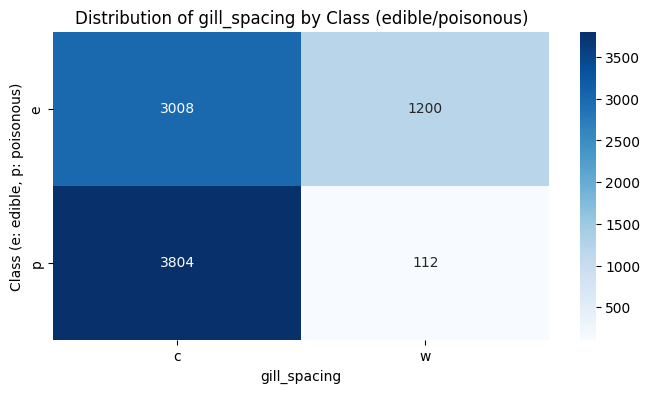

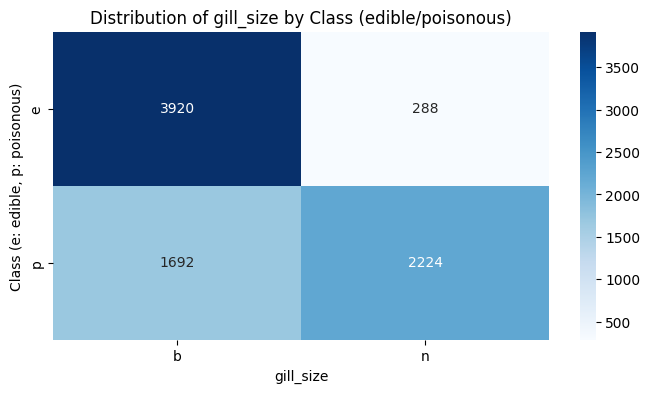

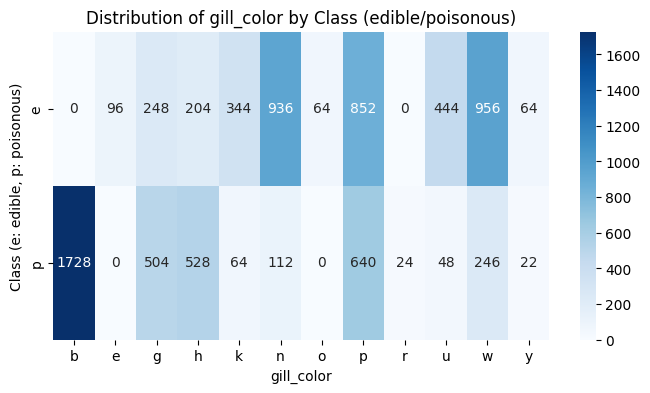

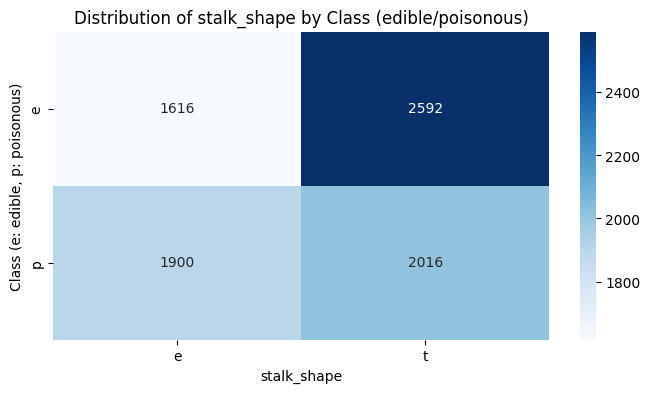

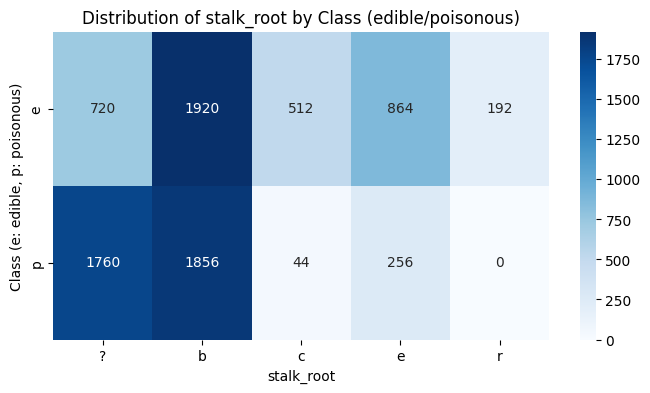

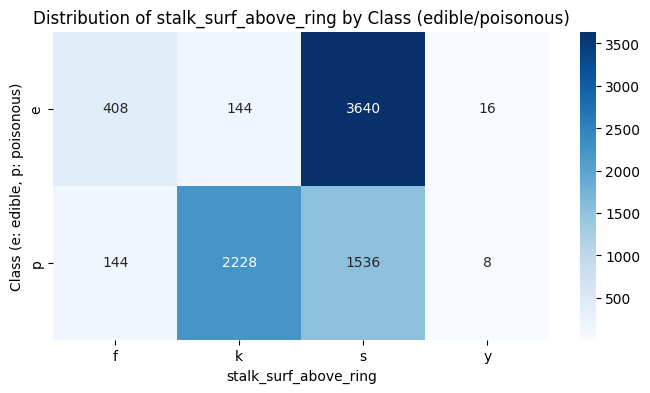

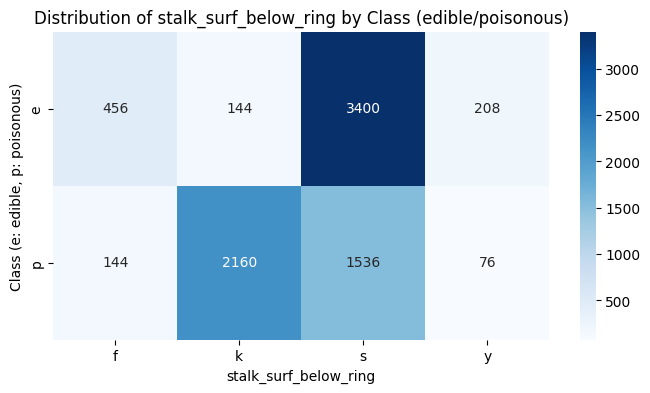

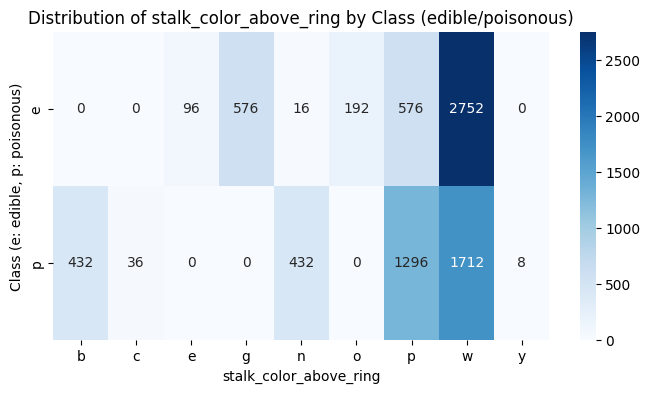

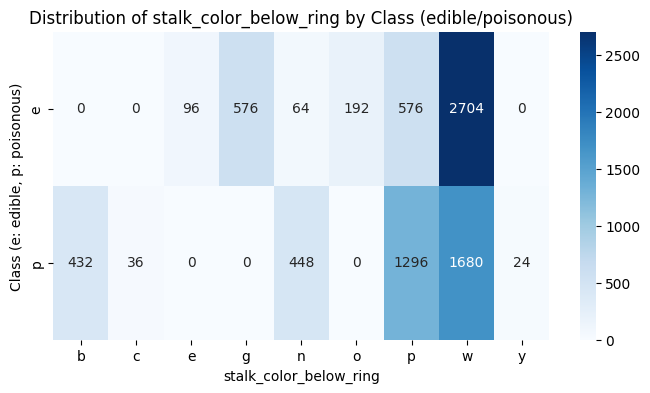

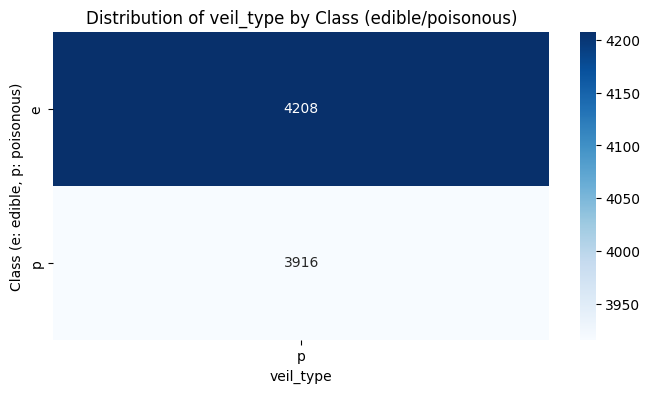

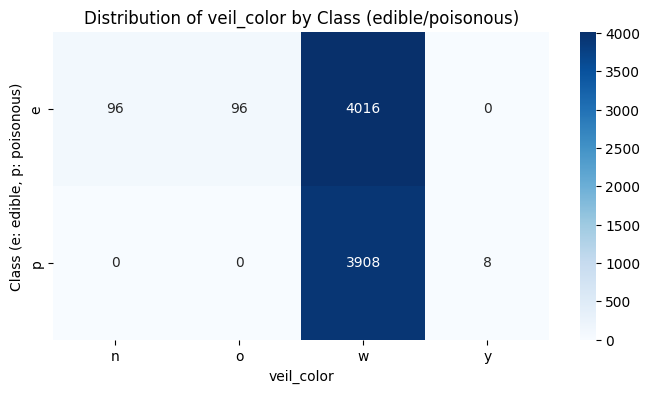

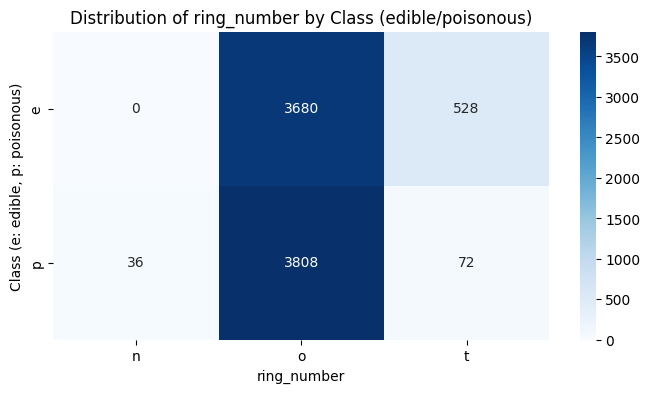

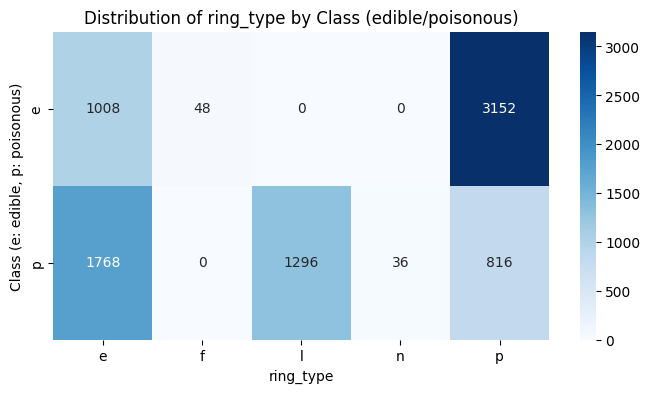

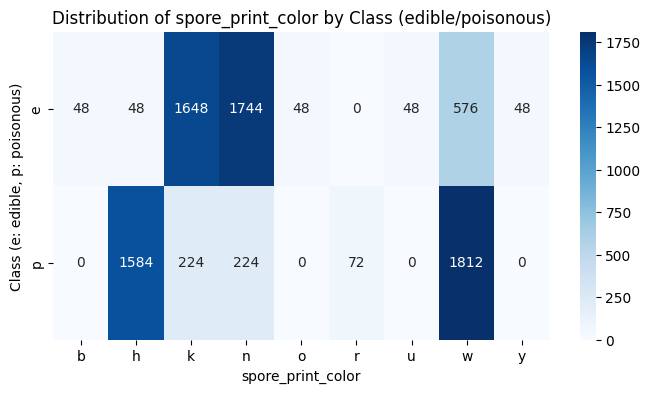

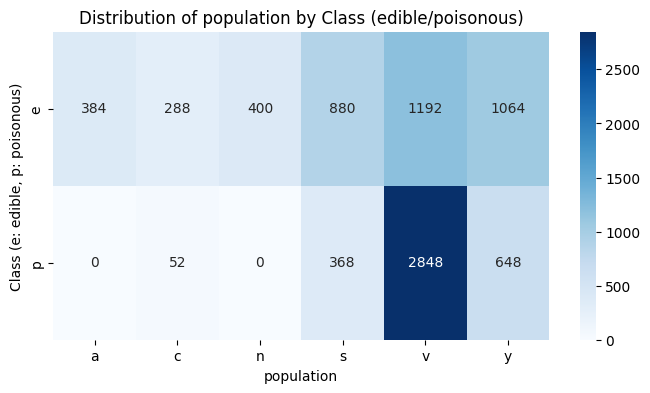

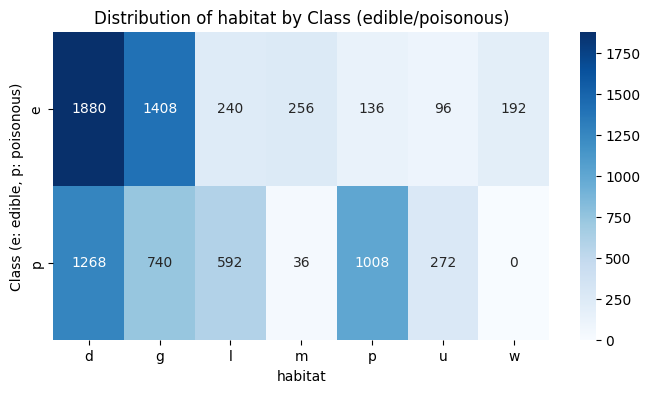

In [ ]:
# --- Visualize Distribution for Each Feature ---
for col in mushroom_cols[1:]:
    count_table = mushrooms.groupby(['class', col]).size().unstack(fill_value=0)
    plt.figure(figsize=(8, 4))
    sns.heatmap(count_table, annot=True, cmap='Blues', fmt='d')
    plt.title(f'Distribution of {col} by Class (edible/poisonous)')
    plt.xlabel(col)
    plt.ylabel('Class (e: edible, p: poisonous)')
    plt.show()

In [ ]:
# --- Frequency-Based Decision Functions per Feature ---
# Calculates the accuracy of predicting mushroom edibility using individual feature frequencies.
# Identifies the feature with the highest predictive accuracy.
results_metrics = []

# Loop through each feature (except the target)
for col in mushroom_cols[1:]:
    temp = mushrooms[['class', col]].copy()    #temporary DataFrame
    freq_counts = temp.groupby(col)['class'].value_counts().unstack(fill_value=0)  # Calculate frequency of 'e' and 'p' for each feature value
    freq_counts['edible_prob'] = freq_counts['e'] / freq_counts.sum(axis=1)
    temp['predicted'] = temp[col].map(lambda val: 'e' if freq_counts.at[val, 'edible_prob'] > 0.5 else 'p')  # Predict 'e' or 'p' based on simple rule

    confusion = pd.crosstab(temp['class'], temp['predicted'], rownames=['Actual'], colnames=['Predicted'], dropna=False)   # table of true and false positive/negative values
    true_edible = confusion.at['e', 'e'] if 'e' in confusion.columns else 0
    true_poison = confusion.at['p', 'p'] if 'p' in confusion.columns else 0
    false_edible = confusion.at['p', 'e'] if 'e' in confusion.columns else 0
    false_poison = confusion.at['e', 'p'] if 'p' in confusion.columns else 0
    acc = (true_edible + true_poison) / (true_edible + true_poison + false_edible + false_poison)   # accuracy

    results_metrics.append((col, true_edible, true_poison, false_edible, false_poison, acc))

results_df = pd.DataFrame(results_metrics, columns=['Feature', 'True-e', 'True-p', 'False-e', 'False-p', 'Accuracy'])
best_feature = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"Most Informative Feature: {best_feature['Feature']} (Accuracy: {best_feature['Accuracy']:.4f})")

Most Informative Feature: odor (Accuracy: 0.9852)


In [ ]:
# ---Naive Bayes Classifier (Sklearn) ---
# CategoricalNB) requires numeric input,
# Label Encoding converts the categorical string values into numeric int labels.

encoded_mush = mushrooms.copy()
encoders = {}

for feature in encoded_mush.columns:
    le = LabelEncoder()
    encoded_mush[feature] = le.fit_transform(encoded_mush[feature])   # Transform: Convert categorical to numeric.
    encoders[feature] = le


# plit Features and Target
X_features = encoded_mush.drop('class', axis=1)
y_target   = encoded_mush['class']

nb_classifier = CategoricalNB()
nb_classifier.fit(X_features, y_target)


# make a pridiction
predictions_nb = nb_classifier.predict(X_features)
print(f"Naive Bayes Model Accuracy: {accuracy_score(y_target, predictions_nb):.4f}")

Naive Bayes Model Accuracy: 0.9567


In [ ]:
# --- Manual Naive Bayes Implementation ---


# # Calculate Log Priors & Basic Stats
# n_samples = len(y_target)
# class_counts = y_target.value_counts()
# unique_classes_encoded = class_counts.index.to_numpy() # e.g., [0, 1]
# log_class_priors = np.log(class_counts / n_samples).to_dict() # {encoded_class: log_prior}, we use log > for numerical stability
# print("Log Class Priors (encoded):", log_class_priors)



# # Calculate Log Conditional Probabilities with Laplace Smoothing
# alpha = 1.0
# # Structure: feature_log_probs[(feature_name, feature_value_encoded)][class_encoded] = log_prob
# feature_log_probs = defaultdict(lambda: defaultdict(float))
# feature_unique_counts = {col: X_features[col].nunique() for col in X_features.columns}

# for feature in X_features.columns:
#     K = feature_unique_counts[feature]
#     # Use encoded_mush to easily group feature values by class
#     counts = encoded_mush.groupby([feature, 'class']).size()
#     for val_encoded in X_features[feature].unique():
#         for cls_encoded in unique_classes_encoded:
#             N_class = class_counts[cls_encoded]
#             count_val_cls = counts.get((val_encoded, cls_encoded), 0)
#             log_prob = np.log((count_val_cls + alpha) / (N_class + alpha * K))
#             feature_log_probs[(feature, val_encoded)][cls_encoded] = log_prob

# # Manual Prediction Function (Slightly more compact definition)
# def manual_naive_bayes_predict_concise(X_encoded_df, log_priors_map, log_conditionals_map, classes):
#     """Predicts class labels using pre-calculated log probabilities."""
#     predictions = []
#     for index, row in X_encoded_df.iterrows():
#         # Start with log priors P(Class)
#         log_probs_per_class = log_priors_map.copy()
#         # Add log likelihoods Sum[log P(Xi | Class)]
#         for feature_name in X_encoded_df.columns:
#             value_encoded = row[feature_name]
#             if (feature_name, value_encoded) in log_conditionals_map:
#                 for cls_encoded in classes:
#                      # .get for safety, default to tiny log prob (-np.inf ensures it won't be picked)
#                     log_probs_per_class[cls_encoded] += log_conditionals_map[(feature_name, value_encoded)].get(cls_encoded, -np.inf)

#         # Choose class with highest log probability
#         predictions.append(max(log_probs_per_class, key=log_probs_per_class.get))
#     return np.array(predictions)

#
# manual_predictions = manual_naive_bayes_predict_concise(
#     X_features,
#     log_class_priors,      # Already {encoded_class: log_prior}
#     feature_log_probs,     # Already {(feature, value): {class: log_prob}}
#     unique_classes_encoded # Array like [0, 1]
# )

# accuracy_manual = accuracy_score(y_target, manual_predictions)
# accuracy_sklearn = accuracy_score(y_target, predictions_nb) # From previous sklearn run
# diff = abs(accuracy_sklearn - accuracy_manual)

# print(f"\nManual Naive Bayes Accuracy (alpha={alpha}): {accuracy_manual:.4f}")
# print(f"Scikit-learn CategoricalNB Accuracy:    {accuracy_sklearn:.4f}")
# print(f"Difference vs scikit-learn NB:          {diff:.6f}")



# Log Prior Probabilities

# Counts class occurrences, calculates log prior probabilities to avoid small nums, and stores them as a dictionary {key: class; value: log piror prob}.
class_counts = y_target.value_counts()
log_priors = np.log(class_counts / len(y_target)).to_dict()

# Log Conditional Probabilities (for the feacher fro each calss) with Laplace Smoothing

# adds a small value to counts > avoid zero probabilities > helps when certain feature values don’t appear in the training data for a class.
alpha = 1.0
log_cond_probs = defaultdict(dict)  # defaultdict > automatically creates a new empty dictionary when try to access a missing key > avoid mistakes in normal dict

for feature in X_features.columns:
    K = X_features[feature].nunique()  # calculates how many different values the current feature can have...
    grouped = encoded_mush.groupby([feature, 'class']).size()

    for value in X_features[feature].unique():
        for cls in class_counts.index:
            count = grouped.get((value, cls), 0)
            total = class_counts[cls]
            log_prob = np.log((count + alpha) / (total + alpha * K))
            log_cond_probs[(feature, value)][cls] = log_prob

# Prediction
def predict_naive_bayes(X, log_priors, log_cond_probs, classes):
    predictions = []
    for _, row in X.iterrows():
        log_probs = {cls: log_priors[cls] for cls in classes}
        for feature in X.columns:
            val = row[feature]
            for cls in classes:
                log_probs[cls] += log_cond_probs.get((feature, val), {}).get(cls, -np.inf)  # add the log conditional probability for the feature value and class.
        predictions.append(max(log_probs, key=log_probs.get))         # picks the class with the highest log probability.
    return predictions


manual_preds = predict_naive_bayes(X_features, log_priors, log_cond_probs, class_counts.index) # predict_naive_bayes() => to predict the class for each sample in the dataset.
accuracy = accuracy_score(y_target, manual_preds)               # compare <>
print(f"Manual Naive Bayes Accuracy: {accuracy:.4f}")


Manual Naive Bayes Accuracy: 0.9567


In [ ]:
# --- Logistic Regression on Log-Odds ---
# Log_odds => the natural logarithm (log) of the odds => = log(P(event)/1-P(event)​) 0 <= the result <= 1

class_totals = mushrooms['class'].value_counts()      # pandas seiries => counts how many times each class (either 'e' for edible or 'p' for poisonous) appears in the 'class' column of the mushrooms dataset.
edible_probability = class_totals['e'] / class_totals.sum()
z_base = np.log(edible_probability) - np.log(1 - edible_probability)    # The difference between these two values gives the base log-odds for a mushroom being edible.

logit_transforms = pd.DataFrame(index=mushrooms.index)    # empty DataFrame => store the transformed log-odds for each feature. It uses the same index as the original mushrooms DataFrame.

for feat in mushroom_cols[1:]:     # except the first column (the target variable).
    group_counts = mushrooms.groupby(feat)['class'].value_counts().unstack(fill_value=1e-10)  # unstack() => reshapes the result into a table (pd) => the feature values: rows and the class counts: columns. ignore the small
    group_counts['edible_prob'] = (group_counts['e'] + 1) / (group_counts['e'] + group_counts['p'] + 2)

    # applies the logistic transformation (log-odds) for each feature in the dataset
    logit_transforms[f'logit_{feat}'] = mushrooms[feat].map(
        lambda x: np.log(group_counts.at[x, 'edible_prob']) - np.log(1 - group_counts.at[x, 'edible_prob'])
    ) - z_base

log_reg = LogisticRegression()
log_reg.fit(logit_transforms, y_target)
predictions_logreg = log_reg.predict(logit_transforms)
print(f"Logistic Regression Accuracy: {accuracy_score(y_target, predictions_logreg):.4f}")

Logistic Regression Accuracy: 1.0000
